## Convolutional Network Training on GPU 

### Importing the Libraries

In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn, optim
from torch.utils.data import DataLoader, Subset

### Defining DataLoader

In [ ]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms

data_path = "originalImages/"

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Transforms ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# --- Dataset ---
dataset = ImageFolder(data_path, transform=transform)


# Create index list
indices = list(range(len(dataset)))

train_idx, test_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=dataset.targets
)


# Create subsets
train_dataset = Subset(dataset=dataset, indices=train_idx)
test_dataset = Subset(dataset=dataset, indices=test_idx)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=6, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=6, pin_memory=True)


### Defining Model Architecture

In [ ]:
class ConvolutionNNET(nn.Module):
    def __init__(self):
        super(ConvolutionNNET, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 128),
            nn.ReLU(),
            nn.Linear(128, 3)  # Assuming 3 Compost, Trash, Recycle classes
        )
    def forward(self, x):
        x = self.features(x)
        return x

### HyperParameters

In [ ]:
import torch
from torch import optim
# Classes are unbalanced so I gotta penalize it for the missed predictions on the minority classes
epochs = 30
lr = 0.001
model = ConvolutionNNET().to(device)

optimzer = optim.Adam(model.parameters(), lr=lr)
class_weights = {
    "Recycle": 12259 / 7766,
    "Trash": 12259 / 3794,
    "Compost": 12259 / 699
}
weights = torch.tensor([class_weights["Recycle"], class_weights["Trash"], class_weights["Compost"]],dtype=torch.float32)
loss_fn = nn.CrossEntropyLoss(weight=weights.to(device))

## Training Loop

In [ ]:
testingaccuaryperepoch = []
trainingaccuaryperepoch = []
losses = []
for epoch in range(epochs):
    model.train()
    trainnig_correct = 0
    training_total = 0

    testing_correct = 0
    testing_total = 0
    print(f"Epoch: {epoch}/30")
    for images, labels in train_loader:
        # Move data to the same device as the model
        images, labels = images.to(device), labels.to(device)
        #forward pass
        pred = model(images)

        #Backwards pass and optimization
        optimzer.zero_grad() # Clear the gradients
        loss = loss_fn(pred, labels) # Calculate the lossb
        loss.backward() # Minimize the loss
        optimzer.step() # Update the parameters

        _, predicted = torch.max(pred.data, 1)
        training_total += labels.size(0)
        trainnig_correct += (predicted == labels).sum().item()
        losses.append(loss.item())

    for images, labels in test_loader:
        model.eval()
        with torch.no_grad():
            pred = model(images.to(device))
            _, predicted = torch.max(pred.data, 1)
            testing_total += labels.size(0)
            testing_correct += (predicted.cpu() == labels).sum().item()

    testingaccuaryperepoch.append(100 * testing_correct / testing_total)
    trainingaccuaryperepoch.append(100 * trainnig_correct / training_total)
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Accuracy: {100 * testing_correct / testing_total:.2f}%")

Epoch: 0/30
Epoch 1/30, Loss: 0.4465876817703247, Accuracy: 63.38%
Epoch: 1/30
Epoch: 2/30
Epoch: 3/30
Epoch: 4/30
Epoch: 5/30
Epoch: 6/30
Epoch: 7/30
Epoch: 8/30
Epoch: 9/30
Epoch: 10/30
Epoch 11/30, Loss: 0.01991407200694084, Accuracy: 75.20%
Epoch: 11/30
Epoch: 12/30
Epoch: 13/30
Epoch: 14/30
Epoch: 15/30
Epoch: 16/30
Epoch: 17/30
Epoch: 18/30
Epoch: 19/30
Epoch: 20/30
Epoch 21/30, Loss: 0.017979593947529793, Accuracy: 76.63%
Epoch: 21/30
Epoch: 22/30
Epoch: 23/30
Epoch: 24/30
Epoch: 25/30
Epoch: 26/30
Epoch: 27/30
Epoch: 28/30
Epoch: 29/30


### Plot Accuracy/Loss

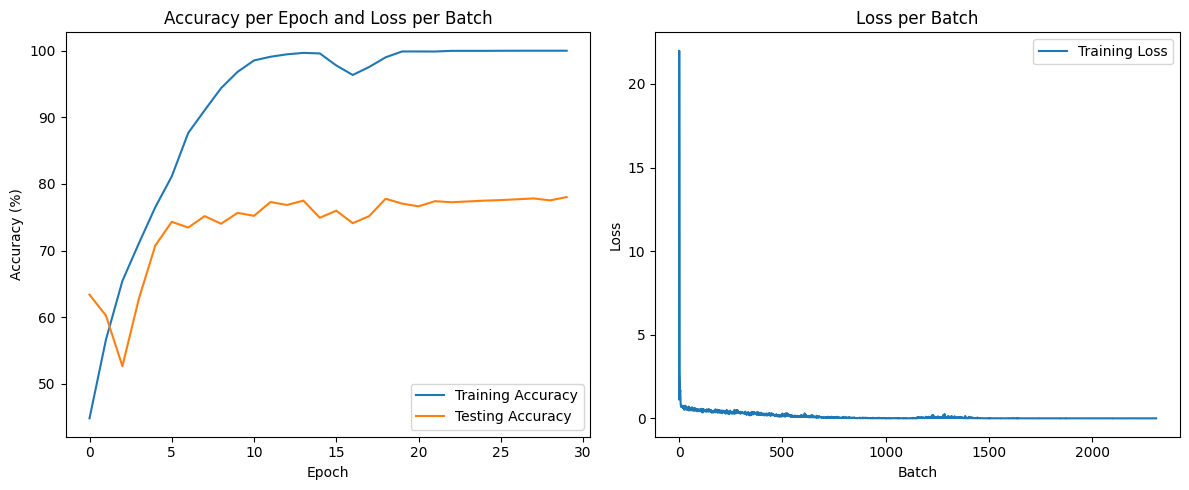

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(trainingaccuaryperepoch, label="Training Accuracy")
plt.plot(testingaccuaryperepoch, label="Testing Accuracy")
plt.title("Accuracy per Epoch and Loss per Batch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(losses, label="Training Loss")
plt.title("Loss per Batch")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import os

# Define the directory to save the model
save_dir = 'savedModels/'

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define the path to save the model
model_save_path = os.path.join(save_dir, 'CNN30Epochs.pth')

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved successfully to {model_save_path}")

Model saved successfully to /content/drive/MyDrive/savedModels/CNN30Epochs.pth


In [ ]:
avg_losses = sum(losses) / len(losses)
print(f"Average Loss: {avg_losses}")